#1. RAY TRACER ODAK

In [1]:
!pip install git+https://github.com/kunguz/odak.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kunguz/odak.git to /tmp/pip-req-build-gi65ddnh
  Running command git clone -q https://github.com/kunguz/odak.git /tmp/pip-req-build-gi65ddnh


In [2]:
import odak
import torch 
import numpy as np 
import sys
import odak.learn.raytracing as ODL
import matplotlib.pyplot as plt
import math


In [3]:
import odak.raytracing as raytracer
import sys
import numpy as np
import odak
from odak.visualize import PLY_object


In [ ]:


def test():
    cad = odak.visualize.PLY_object()
    for i in np.linspace(-10, 10, 5):
        for j in np.linspace(-10, 10, 5):
            color = [
                np.int(np.random.rand()*255),
                np.int(np.random.rand()*255),
                np.int(np.random.rand()*255)
            ]
            cad.draw_a_ray([0., 0., 0.], [i, j, 50.], color=color)
    #cad.save_PLY(savefn='out.ply')
    return

    plt.imshow(cad)
    assert True == True


if __name__ == '__main__':
  pepper = test()

  #plt.imshow(pepper)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inf

In [ ]:
type(pepper)

NoneType

#2.  RAY TRACER FROM SCRATCH

## STEP 1: SETTING UP THE SCENE

In [8]:
def normalize(tensor): 
  norm= tensor/torch.norm(tensor)

  return norm 

# if the ray (line) that starts at camera and goes towards p intersects any object of the scene then
def object_intersection(OB_centre, radius, ray_direction,ray_origin ): 
  a= 1
  sub= ray_origin- OB_centre
  sub = sub.type(torch.float)

  b= 2*torch.dot(ray_direction,sub)
  c=torch.norm(ray_origin-OB_centre)**2 - radius**2

  det=b**2- 4* c

  if det> 0: 
    t1= (-b + torch.sqrt(det))/2
    t2= (-b - torch.sqrt(det))/2

    if t1 > 0 and t2>0:  # only when t1 and t2 are positive 
    # negative t1 and t2 values means the intersection is behine the camera and screen
      return min(t1,t2) # only return the nearest intersection
  return None

# calculating the intersection point to the nearest object

def nearest_object(objects, ray_origin, ray_direction):
  distances= [object_intersection(obj['center'], obj['radius'],ray_direction, ray_origin ) for obj in objects]

  nearest_obj= None
  min_distance= math.inf

  for idx, dist in enumerate(distances): 
    if dist and dist< min_distance: 
      min_distance= dist
      nearest_obj = objects[idx]

  return nearest_obj, min_distance





# STEP 1: SETTING UP THE SCENE
height= 200
width= 300

max_depth= 3

camera_eye= torch.tensor([0., 0., 1.])

ratio= width/height
screen= (-1., 1/ratio, 1., -1/ratio)

objects = [
    { 'center': torch.tensor([-0.2, 0, -1]), 'radius': 0.7, 'ambient': torch.tensor([0.1, 0., 0.]), 
     'diffuse': torch.tensor([0.7, 0., 0.]), 'specular': torch.tensor([1., 1., 1.]), 'shininess': 100},

    { 'center': torch.tensor([0.1, -0.3, 0.]), 'radius': 0.1, 'ambient': torch.tensor([0.1, 0., 0.1]),
     'diffuse': torch.tensor([0.7, 0., 0.7]), 'specular': torch.tensor([1., 1., 1.]), 'shininess': 100 },

    { 'center': torch.tensor([-0.3, 0., 0.]), 'radius': 0.15, 'ambient': torch.tensor([0., 0.1, 0.]),
     'diffuse': torch.tensor([0., 0.6, 0.]), 'specular': torch.tensor([1., 1., 1.]), 'shininess': 100 },

     { 'center': torch.tensor([0, -9000, 0]), 'radius': 9000 - 0.7, 'ambient': torch.tensor([0.1, 0.1, 0.1]), 
      'diffuse': torch.tensor([0.6, 0.6, 0.6]), 'specular': torch.tensor([1., 1., 1.]), 'shininess': 100 }
]

light= {'position': torch.tensor([5.,5.,5.]), 'ambient': torch.tensor([1., 1., 1.]), 
        'diffuse': torch.tensor([1., 1., 1.]), 'specular': torch.tensor([1., 1., 1.])}

image=torch.zeros((height, width, 3))

for i, y in enumerate(torch.linspace(screen[1], screen[3], height)):
  for j, x in enumerate(torch.linspace(screen[0], screen[2], width)):
    print("progress: %d/%d" % (i + 1, height))
    #Creating a ray from the ray equation 
    # ray= camera+ [(pixel- camera)/norm((pixel- camera))] * timetep(destination form camera)

    origin=camera_eye
    pixel= torch.tensor([x, y, 0])
    direction= normalize(pixel-origin)

    nearest_obj, dist_from_O= nearest_object(objects, origin, direction)
   

    # print('dist ', dist_from_O )
    if nearest_obj ==None: 
      continue
    intersection_point= origin + direction * dist_from_O


    #finding the normal to the sphere
    norm_to_surface = normalize(intersection_point - nearest_obj['center'])

    new_origin = intersection_point + 1e-5*norm_to_surface    

    intersection_to_lightR =normalize(light['position'] - new_origin)

    

    _, distance_from_inter = nearest_object(objects,new_origin, intersection_to_lightR)

    intersection_to_lightD = torch.norm(light['position'] - intersection_point )
    isit_shadow= distance_from_inter< intersection_to_lightD

    if isit_shadow:
      continue


   # Additing illumination to the object and determining the colour of each of the sphere by using tthe phong model

    illumination = torch.zeros((3))

    # Ambient
    illumination += nearest_obj['ambient'] * light['ambient']

    # diffuse
    illumination += nearest_obj['diffuse'] * light['diffuse'] * torch.dot(intersection_to_lightR,norm_to_surface)

   # specular
    intersection_to_camera = normalize(camera_eye - intersection_point)
    shy=nearest_obj['shininess']/4
    norm = normalize(intersection_to_lightR + intersection_to_camera)

    illumination += nearest_obj['specular'] * light['specular'] * torch.dot(norm_to_surface, norm )**shy

    # Illumination addition

    #illumination = ill_ambient + ill_specular + ill_diffuse

    # final image

    image[i, j] =torch.clip(illumination, 0, 1)
    # creating objects in the scene for intersection

    #Spheres


    

    
    


plt.figure()
plt.title('The Scene of the simulation')
plt.imshow(image)



Streaming output truncated to the last 5000 lines.
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/200
progress: 49/2

KeyboardInterrupt: ignored

In [9]:
print(type(light))

<class 'dict'>


In [ ]:
#import sys


def test_sphere_intersection():
    import odak.raytracing as raytracer
    ray = raytracer.create_ray_from_two_points([-2., 0., 0.], [10., 0., 0.])
    sphere = raytracer.define_sphere([0.2, 0.3, 0.], 10)
    normal, distance = raytracer.intersect_w_sphere(ray, sphere)

   # print('The normals:', normal)
    #print('The distance:', distance)
    #assert True == True

    return normal, distance


def test_multiple_rays_w_sphere():
    import odak.raytracing as raytracer
    import odak.tools as tools
    end_points = tools.grid_sample(
        no=[5, 5],
        size=[10., 10.],
        center=[0., 0., 100.],
        angles=[0., 0., 0.]
    )
    start_point = [0., 0., 0.]
    rays = raytracer.create_ray_from_two_points(
        start_point,
        end_points
    )
    sphere = raytracer.define_sphere([0., 0., 100.], 20)
    normals, distances = raytracer.intersect_w_sphere(rays, sphere)

    # print(normals)
    # print(distances)

    return normals, distances
    # assert True == True


def test_all():
    test_sphere_intersection()
    test_multiple_rays_w_sphere()


# if __name__ == '__main__':
#     sys.exit(test_all())

test_sphere_intersection()


(array([[10.19549899,  0.        ,  0.        ],
        [-0.9995499 ,  0.03      ,  0.        ]]), array([12.19549899]))

In [ ]:
#Setting up the scene 

height  = 300
width = 400
camera= torch.tensor([-2., 0., 0.])

ratio= width/height
screen= (-1., 1/ratio, 1., -1/ratio)

image=torch.zeros((height, width, 3))

# pixel= Origin + t* direction

light= {'position': torch.tensor([150.,150.,10.]), 'ambient': torch.tensor([1., 1., 1.]), 
        'diffuse': torch.tensor([1., 1., 1.]), 'specular': torch.tensor([1., 1., 1.])}

sphere_details= {'centre': torch.tensor([0., 0., 0.]) ,'radius': 10,'ambient': torch.tensor([0.1, 0, 0]), 'diffuse': torch.tensor([0.7, 0, 0]), 'specular': torch.tensor([1, 1, 1]),
                  'shininess': 100, 'reflection': 0.5 }


for i, x in enumerate(torch.linspace(screen[1], screen[3], height)):
  for j, y in enumerate(torch.linspace(screen[0], screen[2], width)):

    origin= camera
    pixels=torch.tensor([x, y, 0.])


    n_object, distance_from_O = test_multiple_rays_w_sphere()

    distance_from_O= torch.from_numpy(distance_from_O)
    n_object= torch.from_numpy(n_object)

    for n in n_object:
      for d in distance_from_O:
        direction= normalize(pixels-origin)
        if n is None: 
          continue


        intersection= origin + d * direction

        shifted_point= intersection + 1e-5* n[1]
        intersection_to_light = normalize(light['position'] - shifted_point)

        intersection_to_light_dist = torch.norm(light['position'] - intersection)

        illu= torch.zeros((3))
      # light['position'] = torch.transpose(light )

        # ambient

        illu += sphere_details['ambient'] * light['ambient']

        #diffuse
        illu += sphere_details['diffuse'] * light['diffuse'] * torch.dot(intersection_to_light,n[0])

        # specular
        intersection_to_origin = normalize(camera - intersection)
        H = normalize(intersection_to_origin + intersection_to_light)
        illu += sphere_details['specular'] * light['specular'] * torch.dot(n[0], H) **(sphere_details['shininess']/4)

        image[i,j] = torch.clip(illu, 0, 1)

    print("progress: %d/%d" % (i + 1, height))

plt.figure()
plt.title('Odak example')
plt.imshow(image)



Streaming output truncated to the last 5000 lines.
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121/300
progress: 121

## ODAK

In [7]:
def intersect_ray_triangle():
  # give points to create a ray 

  ray_start_0 = torch.tensor([5.,5., 0.])
  ray_end_0 = torch.tensor([10., 10., 0.])

  # create ray from 2 points
  ray_0= ODL.create_ray_from_two_points(ray_start_0, ray_end_0)

  # Creating another ray
  ray_start_1 = torch.tensor([5.,5., 0.])
  ray_end_1 = torch.tensor([0., 100., 1000.])

   # create ray from 2 points
  ray_1= ODL.create_ray_from_two_points(ray_start_1, ray_end_1)

  # Create a triangle for intersection
  triangle = torch.tensor([[50., 50., 0.], 
                           [-5., -5., 0.], 
                          [0., 50., 0. ]
                           ]) 
  # intersecting with triangle 
  norm_0, dist_0= ODL.intersect_w_triangle(ray_0, triangle)
  #intersection_0 = ray_start_0 + dist_0 * ray_0




  norm_1, dist_1= ODL.intersect_w_triangle(ray_1, triangle)
  
  #if norm_0 or norm_1 is None: 
    




  #print(dist_0)
  #print(dist_1)

  #assert True == True #what does this mean??

  return norm_0, dist_0, ray_0

# Setting up a scene


height  = 300
width = 400
camera= torch.tensor([5., 5., 0.])

ratio= width/height
screen= (-1., 1/ratio, 1., -1/ratio)

image=torch.zeros((height, width, 3))

# pixel= Origin + t* direction

light= {'position': torch.tensor([25.,25.,5.]), 'ambient': torch.tensor([1., 1., 1.]), 
        'diffuse': torch.tensor([1., 1., 1.]), 'specular': torch.tensor([1., 1., 1.])}

triange_details= {'ambient': torch.tensor([0.1, 0, 0]), 'diffuse': torch.tensor([0.7, 0, 0]), 'specular': torch.tensor([1, 1, 1]),
                  'shininess': 100, 'reflection': 0.5 }

for i, x in enumerate(torch.linspace(screen[1], screen[3], height)):
  for j, y in enumerate(torch.linspace(screen[0], screen[2], width)):

    origin= camera
    pixels=torch.tensor([x, y, 0.])


    n_object, distance_from_O, _ = intersect_ray_triangle()
    #print(type(distance_from_O))
    direction= normalize(pixels-origin)
    if n_object is None: 
      continue

    intersection= origin + distance_from_O * direction

    shifted_point= intersection + 1e-5* n_object[1]
    intersection_to_light = normalize(light['position'] - shifted_point)

    intersection_to_light_dist = torch.norm(light['position'] - intersection)

    illu= torch.zeros((3))
   # light['position'] = torch.transpose(light )

    # ambient

    illu += triange_details['ambient'] * light['ambient']

    #diffuse
    illu += triange_details['diffuse'] * light['diffuse'] * torch.dot(intersection_to_light,n_object[0])

    # specular
    intersection_to_origin = normalize(camera - intersection)
    H = normalize(intersection_to_origin + intersection_to_light)
    illu += triange_details['specular'] * light['specular'] * torch.dot(n_object[0], H) **(triange_details['shininess']/4)

    image[i,j] = torch.clip(illu, 0, 1)

    print("progress: %d/%d" % (i + 1, height))

plt.figure()
plt.title('Odak example')
plt.imshow(image)
# if __name__ == '__main__':
#     sys.exit(intersect_ray_triangle())



KeyboardInterrupt: ignored

In [ ]:
n_object


In [ ]:
# intersection_to_light,
n_object[0]

## STEP 2: CREATING A RAY

In [ ]:
torch.zeros((3))

In [ ]:
from odak import raytracing

ray =raytracing



In [ ]:
plt.plot (n_object)

## NUMPY VERSION OF RAY TRACING FORM SCRATCH

Streaming output truncated to the last 5000 lines.
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/200
184/2

Text(0.5, 1.0, 'Numpy version')

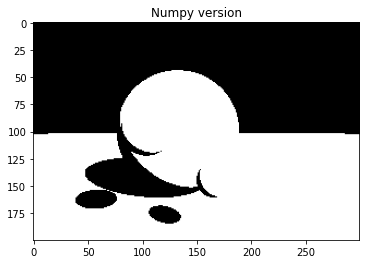

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def normalize(vector):
    return vector / np.linalg.norm(vector)

def reflected(vector, axis):
    return vector - 2 * np.dot(vector, axis) * axis

def sphere_intersect(center, radius, ray_origin, ray_direction):
    b = 2 * np.dot(ray_direction, ray_origin - center)
    c = np.linalg.norm(ray_origin - center) ** 2 - radius ** 2
    delta = b ** 2 - 4 * c
    if delta > 0:
        t1 = (-b + np.sqrt(delta)) / 2
        t2 = (-b - np.sqrt(delta)) / 2
        if t1 > 0 and t2 > 0:
            return min(t1, t2)
    return None

def nearest_intersected_object(objects, ray_origin, ray_direction):
    distances = [sphere_intersect(obj['center'], obj['radius'], ray_origin, ray_direction) for obj in objects]
    nearest_object = None
    min_distance = np.inf
    for index, distance in enumerate(distances):
        if distance and distance < min_distance:
            min_distance = distance
            nearest_object = objects[index]
    return nearest_object, min_distance

width = 300
height = 200

# max_depth = 3

camera = np.array([0, 0, 1])
ratio = float(width) / height
screen = (-1, 1 / ratio, 1, -1 / ratio) # left, top, right, bottom

light = { 'position': np.array([5, 5, 5]), 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]) }

objects = [
    { 'center': np.array([-0.2, 0, -1]), 'radius': 0.7, 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]), 'shininess': 1, 'reflection': 1 },
    { 'center': np.array([0.1, -0.3, 0]), 'radius': 0.1, 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]), 'shininess': 1, 'reflection': 1 },
    { 'center': np.array([-0.3, 0, 0]), 'radius': 0.15, 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]), 'shininess': 1, 'reflection': 1 },
    { 'center': np.array([0, -9000, 0]), 'radius': 9000 - 0.7, 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]), 'shininess': 1, 'reflection': 1 }
]

image = np.zeros((height, width, 3))
for i, y in enumerate(np.linspace(screen[1], screen[3], height)):
    for j, x in enumerate(np.linspace(screen[0], screen[2], width)):
        # screen is on origin
        pixel = np.array([x, y, 0])
        origin = camera
        direction = normalize(pixel - origin)

        # color = np.zeros((3))
        # reflection = 1

        # for k in range(max_depth):
            # check for intersections
        nearest_object, min_distance = nearest_intersected_object(objects, origin, direction)
        if nearest_object is None:
            continue

        intersection = origin + min_distance * direction
        normal_to_surface = normalize(intersection - nearest_object['center'])
        shifted_point = intersection + 1e-5 * normal_to_surface
        intersection_to_light = normalize(light['position'] - shifted_point)

        _, min_distance = nearest_intersected_object(objects, shifted_point, intersection_to_light)
        intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)
        is_shadowed = min_distance < intersection_to_light_distance

        if is_shadowed:
            continue

        illumination = np.zeros((3))

        # ambiant
        illumination += nearest_object['ambient'] * light['ambient']

        # diffuse
        illumination += nearest_object['diffuse'] * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)

        # specular
        intersection_to_camera = normalize(camera - intersection)
        H = normalize(intersection_to_light + intersection_to_camera)
        illumination += nearest_object['specular'] * light['specular'] * np.dot(normal_to_surface, H) ** (nearest_object['shininess'] / 4)

            # reflection
           # color += reflection * illumination
            #reflection *= nearest_object['reflection']

            #origin = shifted_point
            #direction = reflected(direction, normal_to_surface)

        image[i, j] = np.clip(illumination, 0, 1)
        print("%d/%d" % (i + 1, height))

plt.imshow(image)
plt.title('Numpy version')


In [ ]:


#FROM https://github.com/orest-d/raytorch/blob/master/test1.py
import torch
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cpu")
a=torch.tensor([[1,0.01],[0,2]],dtype=torch.float, device=device)

rays = torch.tensor([[[x,0,0,1],[0,1,0,0]] for x in np.linspace(-0.9,0.9,200)],dtype=torch.float, device=device)
#print (rays)

scene = torch.tensor([
    [
      [ 1  , 0  , 0  , 0  ],
      [ 0  , 0  , 0  ,-0.5],
      [ 0  , 0  , 0  , 0  ],
      [ 0  ,-0.5, 0  , 0  ]
    ],
    [
      [ 1  , 0  , 0  , 0  ],
      [ 0  , 1  , 0  , 0  ],
      [ 0  , 0  , 0  , 0  ],
      [ 0  , 0  , 0  ,-1  ]
    ]
],dtype=torch.float, device=device)
M=scene[0]
M=scene[1]

# print (scene.size())
# print (rays.size())
# print ("M",M)
#print ("M2",M2)
#rr=M.dot(rays)
rb = rays.view(-1,4)
# print (rb)
# print("M rays")
Mr = M.matmul(rb.transpose(0,1)).transpose(0,1).view(-1,2,4).transpose(1,2)
# print("Mr",Mr.size())
# print (Mr)
r=rays
# print("r",r.size())
# print (r)


rMr = r.bmm(Mr)
# print(rMr)
D= rMr[:,0,1]*rMr[:,0,1]+rMr[:,1,0]*rMr[:,1,0]+2*rMr[:,0,1]*rMr[:,1,0]-4*rMr[:,0,0]*rMr[:,1,1]
# print(rMr[:,0,0])
# print(rMr[:,0,1])
# print(rMr[:,1,1])
# print(D)
t0 = -rMr[:,0,0]/(rMr[:,0,1] + rMr[:,1,0])
t1 = (-rMr[:,0,1]-rMr[:,1,0] + torch.sqrt(D))/(2*rMr[:,1,1])
t2 = (-rMr[:,0,1]-rMr[:,1,0] - torch.sqrt(D))/(2*rMr[:,1,1])


t=torch.where(rMr[:,1,1]==0.0, t0, torch.where(t1<0, t2, torch.where(t2<0,t1,torch.min(t1,t2))))
# print(t)
# print(rays.size())
rv = rays[:,1,:]
rp = rays[:,0,:]
#plt.plot(rays[:,0,0].numpy(), rays[:,0,1].numpy(), "bo")
rays[:,0,:] += t.view(1,-1).transpose(0,1)*rv
plt.plot(rays[:,0,0].numpy(), rays[:,0,1].numpy(), "go")

# print("rv",rv.size(),rv)
# print(t.view(1,-1).size(), t.view(1,-1))
# print(t.view(1,-1).transpose(0,1)*rv)

rp = rays[:,0,:]
#print ("rp",rp.size(),"\n",rp)
#print ("M",M.size(),"\n",M)

normals = rp.matmul(M) + M.matmul(rp.transpose(0,1)).transpose(0,1)
normals[:,3]=0
#print ("normals",normals.size(),"\n",normals)
nb = normals.view(-1,1,4)
#print ("nb",nb.size(),"\n",nb)
nbT = nb.transpose(1,2)
#print ("nbT",nbT.size(),"\n",nbT)

norm = torch.sqrt(torch.bmm(nb,nbT))
#print ("norm",norm.size(),"\n",norm)
normals/=norm.view(-1,1)
#print("normals",normals.size(),"\n",normals)
x = rays[:,0,0].numpy()
y = rays[:,0,1].numpy()
dx= normals[:,0].numpy()
dy= normals[:,1].numpy()

for x,y,dx,dy in zip (x,y,dx,dy):
    plt.arrow(x,y,dx,dy)


nl = normals.view(-1,1,4)
#print ("nl",nl.size(),"\n",nl)
rvr = rays[:,1,:].view(-1,4,1)
#print("rvr",rvr.size(),rvr)

overlap = torch.bmm(nl,rvr).view(-1,1)
#print ("overlap",overlap.size(),"\n",overlap)
projection = normals*overlap.view(-1,1)
##print ("projection",projection.size(),"\n",projection)

x = rays[:,0,0].numpy()
y = rays[:,0,1].numpy()
dx= projection[:,0].numpy()
dy= projection[:,1].numpy()

for x,y,dx,dy in zip (x,y,dx,dy):
    plt.arrow(x,y,dx,dy,color="r")

reflection = rays[:,1,:]-2*projection
#print ("reflection",reflection.size(),"\n",reflection)
rays[:,1,:]=reflection

x = rays[:,0,0].numpy()
y = rays[:,0,1].numpy()
dx= reflection[:,0].numpy()
dy= reflection[:,1].numpy()
for x,y,dx,dy in zip (x,y,dx,dy):
    plt.arrow(x,y,dx,dy,color="g")

#print("M2 rays")
#print (M2.matmul(rb.transpose(0,1)))

x=np.linspace(-0.9,0.9,100)
plt.plot(x,x*x)
plt.plot(x,np.sqrt(1-x*x))


plt.xlim(-2,2)
plt.ylim(-1,3)
plt.show()


# Another ODAK example of ray tracing

In [ ]:
def example_of_ray_tracing_3():
    #ray         = odak.raytracing()

    import odak.raytracing as ray 
    # Be careful points and pitch must be float
    pitch       = 10.
    cornercube0 = ray.plotcornercube(0,0,0,pitch,revert=False)
    cornercube1 = ray.plotcornercube(pitch/math.sqrt(3),-pitch/3,0,pitch,revert=True)
    vector0     = ray.createvector((1.,2.1,10.),(90,90,0))
    vector1     = ray.createvector((1.,1.,10.),(90,90,0))
    vector2     = ray.createvector((4.,-4.,10.),(90,90,0))
    vectorlist  = [vector0,vector1,vector2]
    cornercubes = [cornercube0,cornercube1]
    for vectors in vectorlist:
        for cubes in cornercubes:
            rayslist          = []
            distance          = 2
            rayslist.append(vectors)
            for rays in rayslist:
                if len(rayslist) > 3:
#                    rays[1] = -rays[1]
                    ray.plotvector(rays,10)
                    break
                for points in cubes:
                    distance,normvec = ray.findintersurface(rays,(points[0],points[1],points[2]))
                    if ray.isitontriangle(normvec[0],points[0],points[1],points[2]) == True:
                        ray.plotvector(normvec,pitch/10,'r')
                        ray.plotvector(rays,distance)
                        reflectvector = ray.reflect(rays,normvec)
                        rayslist.append(reflectvector)
    ray.defineplotshape((-5,5),(-5,5),(0,10))
    ray.showplot()
    return True


In [ ]:
def pattern(distance):
    import odak.raytracing as ray
    source0    = np.array([ 1.,0.,0.])
    source1    = np.array([-1.,0.,0.])
    rectx      = 20.
    recty      = 20.
    nx         = 1000
    ny         = 1000
    wavelength = 532*10**-9
    result     = np.zeros((nx,ny))
    for ix in range(0,nx): 
        for iy in range(0,ny):
            x     = rectx*2./nx*ix-rectx
            y     = recty*2./ny*iy-recty
            point = np.array([x,y,distance])
            z0    = np.sqrt(np.sum((point-source0)**2))*2*np.pi/wavelength
            z1    = np.sqrt(np.sum((point-source1)**2))*2*np.pi/wavelength
            pd    = np.abs(z0-z1)
            result[ix,iy] = 1.+np.cos(pd)
            y=0
    plt.imshow(result,cmap='gray')
    plt.colorbar()
    plt.show()
    #scipy.misc.imsave('/output/result_%s.png' % distance,result)
    print(distance)
    return True

In [ ]:
pattern(1000.)